캔의 상품을 인쇄하지 못한 상태에서, 상품을 여러가지 특징으로 분류할 수 있을까?

의문 : 와인의 알코올 도수, 당도, pH값으로 종류를 구별하려면 로지스틱 회귀 모델을 적용할 수 있는가?

일단 시도해본다.

In [1]:
# class가 양성(1)이면 화이트 와인, 0이면 레드와인으로 분류한다.
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [2]:
wine.info()
# 현재 누락된 값은 없는 것 같다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [3]:
# 알코올, 당도, PH값의 scale이 다르다는 것을 확인할 수 있다.
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [4]:
# 데이터를 훈련 세트와 테스트 세트로 나눈다.
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class'].to_numpy()

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [5]:
# scale을 맞춰주기 위해서 데이터 표준화를 한다.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)
print(train_scaled[:5])
print(test_scaled[:5])

[[ 0.01376574  0.4646116  -0.16888369]
 [ 1.60871671 -0.70299854  0.26967864]
 [ 1.10504798 -0.70299854  1.20945505]
 [ 1.0211032  -0.89065017  0.958848  ]
 [-0.99357172  2.07007555 -0.67009777]]
[[ 1.44082714  1.52797084  0.26967864]
 [-0.48990299 -0.68214836  0.3323304 ]
 [ 1.27293756  0.40206106 -0.23153545]
 [-0.82568214  1.19436794 -0.60744601]
 [-1.32935087  1.75732283 -0.67009777]]


In [6]:
# 로지스틱 회귀 모델을 훈련합니다.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

# 결과 : 0.780으로 훈련 및 테스트 세트 점수가 모두 낮으니 과소적합된 것으로 확인

0.7808350971714451
0.7776923076923077


In [7]:
# 모델이 학습한 계수와 절편 출력
print(lr.coef_, lr.intercept_)

# 모델이 0.512 * 알코올 도수 + 1.673 * 당도 + -0.687 * pH + 1.817를 계산하여 이 값이 0보다 크면 화이트 와인으로 분류한다.

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


결정 트리(Decision Tree) 모델의 장점은 "사람에게 이유를 설명하기 쉽다"라는 것이다.

DecisonTreeClassifier 클래스를 사용하여 설명을 해보자

In [8]:
# 트리 결정 모델을 사용하여 학습한다.
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

# 결과 : 과대적합 상태, 훈련 : 0.996, 테스트 0.858

0.996921300750433
0.8592307692307692


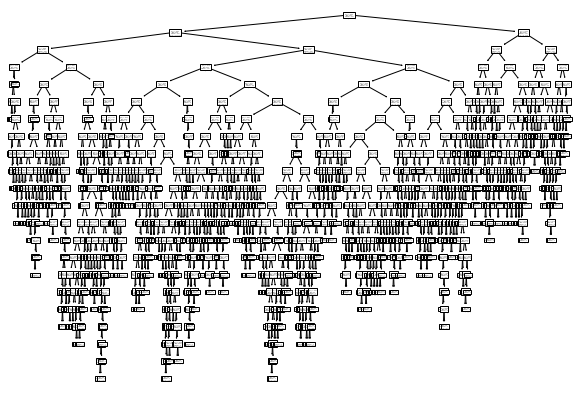

In [9]:
# 그래프로 그려본다.
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 7))
plot_tree(dt)
plt.show()


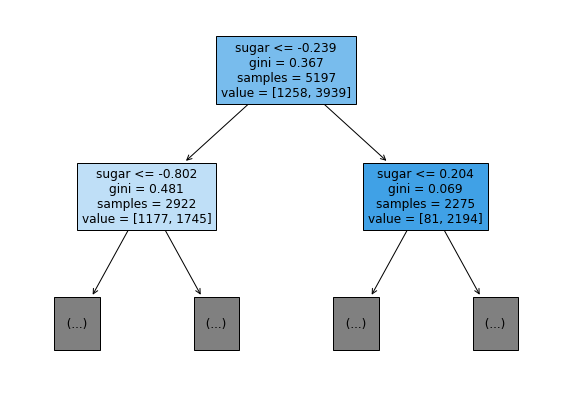

In [10]:
plt.figure(figsize=(10, 7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()


# 결과 설명 : 당도에 따라서 왼쪽 오른쪽으로 나뉜다.
# gini 불순도 = 1 - (은성 클래스 비율의 제곱 + 양성 클래스 비율의 제곱)
# 1 - ((1258 / 5197)^2 + (3939/5197)^2) = 0.367
# 불순도 종류에는 지니 불순도와 엔트로피 불순도 2가지 종류가 있으나 결과의 차이는 크지 않다.

In [11]:
# 가지치기를 하면 점수가 나아질 것이다.
# 루트 노드 아래로 최대 3개의 노드까지만 성장한다.
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


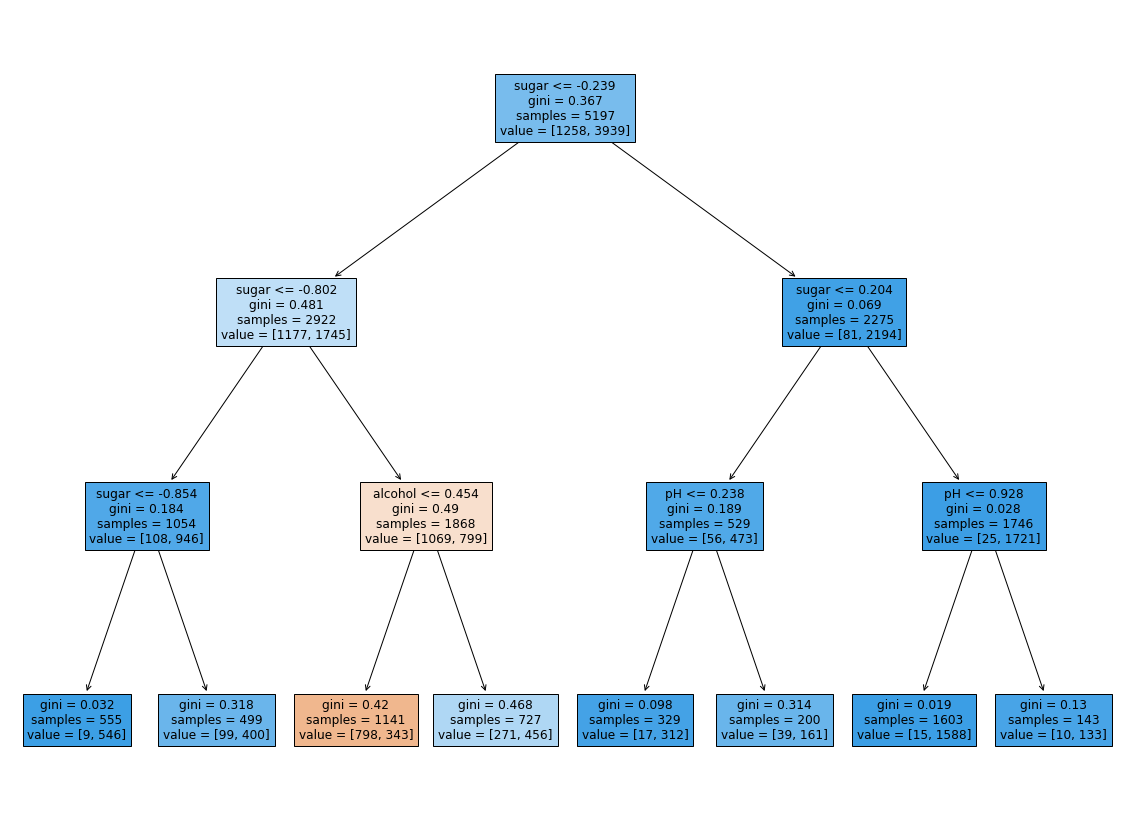

In [12]:
# 그래프로 그려본다.
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

0.8454877814123533
0.8415384615384616


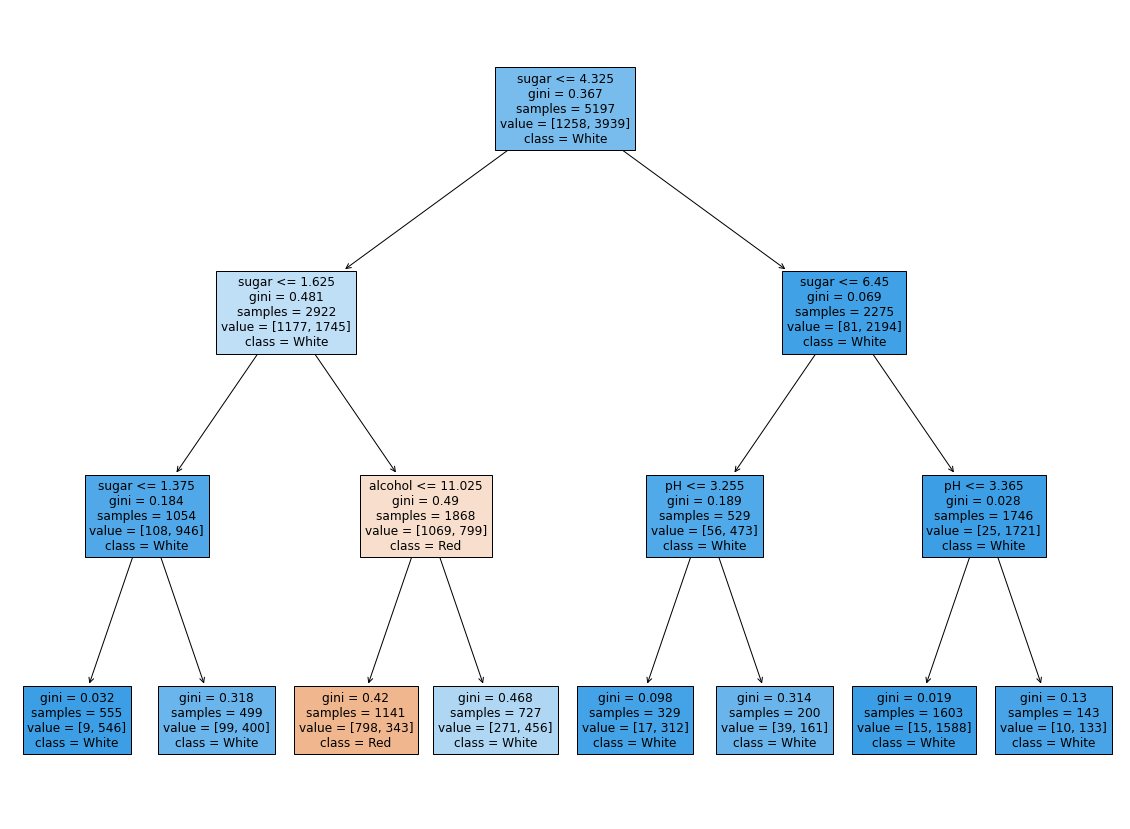

In [19]:
# 데이터를 정규화하지 않는 것으로 실행해보고, 트리를 전에 만든 것과 비교해본다.
# 트리 결정 구조는 데이터를 정규화하지 않아도 사용할 수 있다.
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))


# 그래프로 그려본다.
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'], class_names = ['Red','White'])
plt.show()

In [15]:
# 알코올, 당도, pH에 대한 트리 결정구조의 특성 중요도를 확인
print(dt.feature_importances_)

# 결과 : 당도가 0.868로 중요도가 가장 높은 특성이다.
# 알코올, 당도, pH
# [0.12345626 0.86862934 0.0079144 ]


[0.12345626 0.86862934 0.0079144 ]


지금까지 트리 학습 구조를 사용해봤다. 
더 개선된 알고리즘은 앙상블 학습 알고리즘으로 신경망과 함께 가장 높은 성능을 내고 있다.

In [33]:
# tree가 도출해낸 결과를 확인

from scipy import stats
tree_target = dt.predict(test_input)
display(tree_target)

stats.describe(tree_target)

array([1., 0., 1., ..., 1., 1., 1.])

DescribeResult(nobs=1300, minmax=(0.0, 1.0), mean=0.7761538461538462, variance=0.17387280156333276, skewness=-1.3250503057028646, kurtosis=-0.244241687356745)

In [34]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8874350586877044
0.8615384615384616


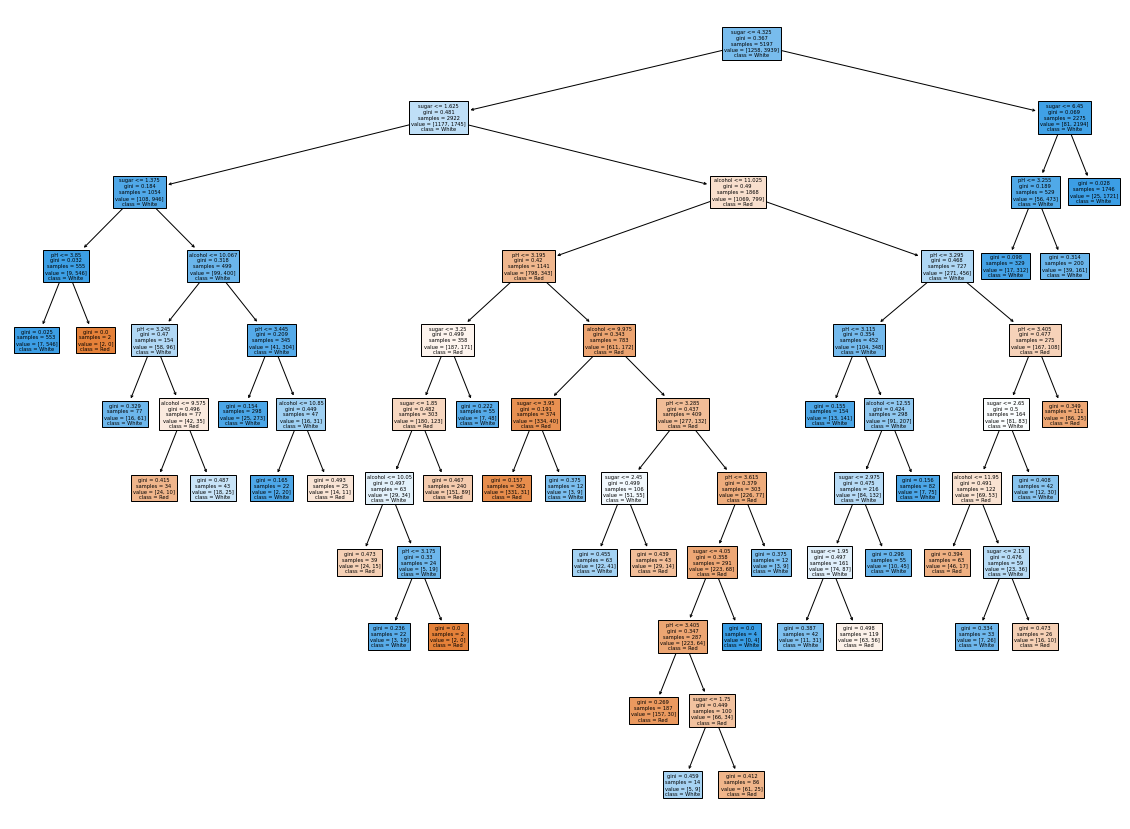

In [36]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'], class_names = ['Red','White'])
plt.show()